
## Case Study: Classifying Smokers vs Non Smokers


## Dataset Description


*   **age**: age of primary beneficiary
*   **sex**: insurance contractor gender, female, male
*   **bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
*   **children**: Number of children covered by health insurance / Number of dependents
*   **smoker**: Smoking
*   **region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
*   **charges**: Individual medical costs billed by health insurance


# Install libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

#Load the dataset

In [ ]:
# clone git repo
!git clone https://github.com/zaka-ai/medical-cost-prediction

# change working directory
%cd medical-cost-prediction/data/

fatal: destination path 'medical-cost-prediction' already exists and is not an empty directory.
/content/medical-cost-prediction/data


In [ ]:
data= pd.read_csv('/content/medical-cost-prediction/data/insurance.csv')

explore the shape of data

In [ ]:
print(f'this dataset contains {data.shape[0]} rows and {data.shape[1]} columns')

this dataset contains 1338 rows and 7 columns


In [ ]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1335.000000,1338.000000,1338.000000
mean,39.207025,30.661423,1.094918,13270.422265
std,14.049960,6.101038,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.302500,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.687500,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#Data Cleaning and processing

In [ ]:
# Check null values
print(data.isnull().sum())
print('Check duplicates')
print(data.duplicated().sum())


age         0
sex         0
bmi         3
children    0
smoker      0
region      0
charges     0
dtype: int64
Check duplicates
1


In [ ]:
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)

Check data is cleaned

In [ ]:
print(data.isna().any())
print(data.duplicated().any())

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool
False


Check **'smoker'** column distribution

There is 274 smokers, and 1060 non_smokers


<BarContainer object of 2 artists>

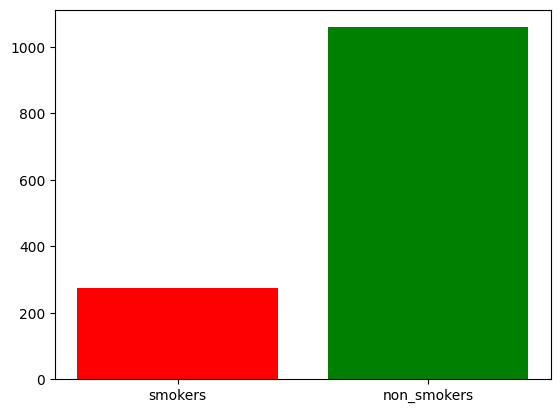

In [ ]:

smokers = data[data['smoker'] == 'yes']
non_smokers = data[data['smoker'] == 'no']

print(f'There is {len(smokers)} smokers, and {len(non_smokers)} non_smokers')
plt.bar(['smokers','non_smokers'], [len(smokers), len(non_smokers)],color=['red','green'])

we can see that the dataset is not balanced

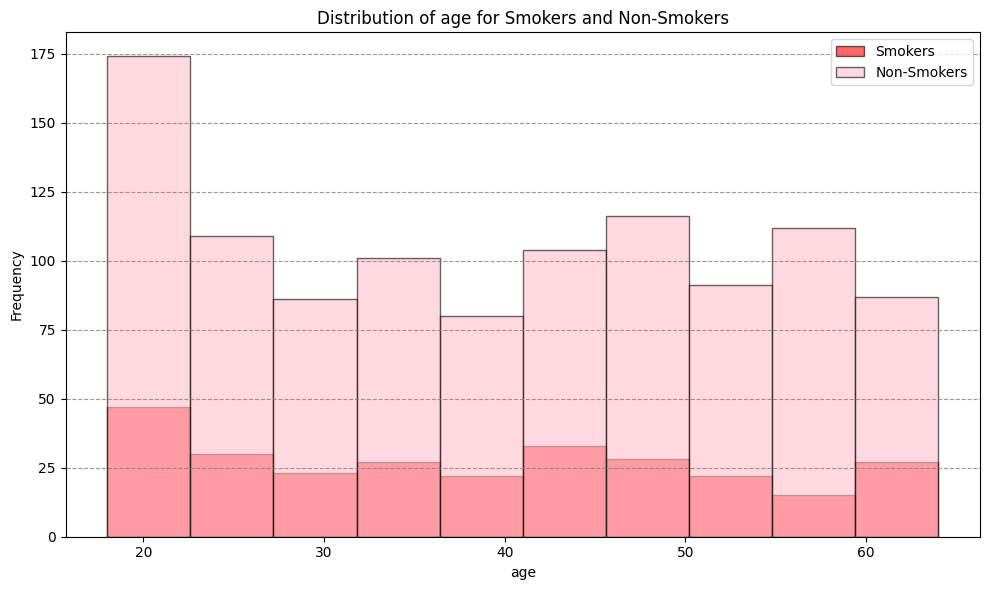

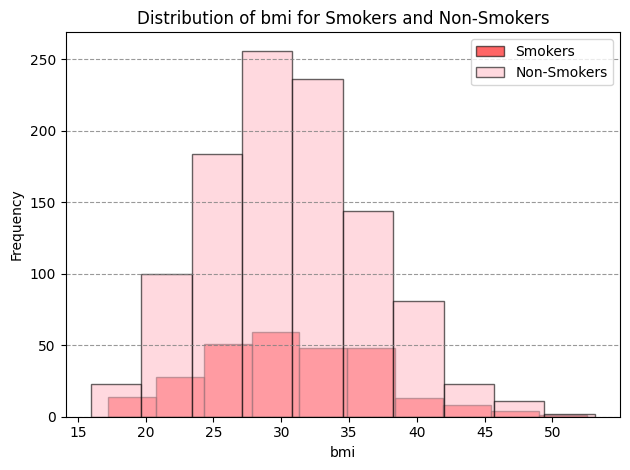

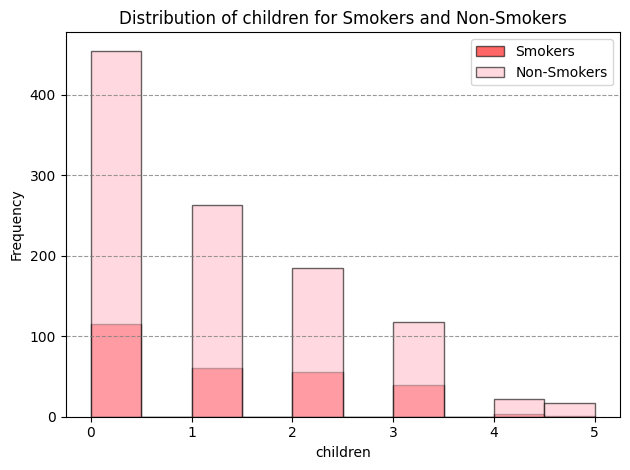

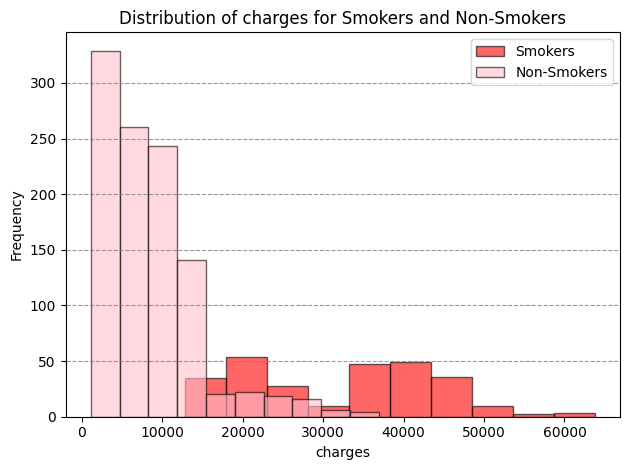

In [ ]:
#define numerical features
numerical_features = ['age', 'bmi', 'children', 'charges']

plt.figure(figsize=(10, 6))

for feature in numerical_features:
    plt.hist(smokers[feature], color='red', alpha=0.6, label=f'Smokers', edgecolor='black')
    plt.hist(non_smokers[feature], color='pink', alpha=0.6, label=f'Non-Smokers', edgecolor='black')

    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {feature} for Smokers and Non-Smokers')
    plt.legend()

    plt.grid(axis='y', linestyle='--', linewidth=0.8, color='gray', alpha=0.8)
    plt.tight_layout()

    plt.show()

Interpreatation:<br>




**Age**: the overlap between smokers and non-smokers suggests that age is not a definitive indicator of smoking status.

**BMI**: The BMI distributions for smokers and non-smokers indicates that  this feature is unlikely to be a strong determinant of smoking behavior.

**Children**: The distribution of the number of children for smokers and non-smokers shows a similar pattern. This suggests that the number of children is unlikely to be a significant predictor of smoking status.

**Medical Charges:** The distribution of medical charges demonstrates a clear distinction between smokers and non-smokers, with smokers generally incurring significantly higher charges. This makes medical charges a strong predictor of smoking status.

**To sum up, medical charges show the most distinct separation between smokers and non-smokers. This makes it the most valuable  feature for predicting whether an individual is a smoker.**

Let's check the distribution of smoker and non-smoker based on categorical features

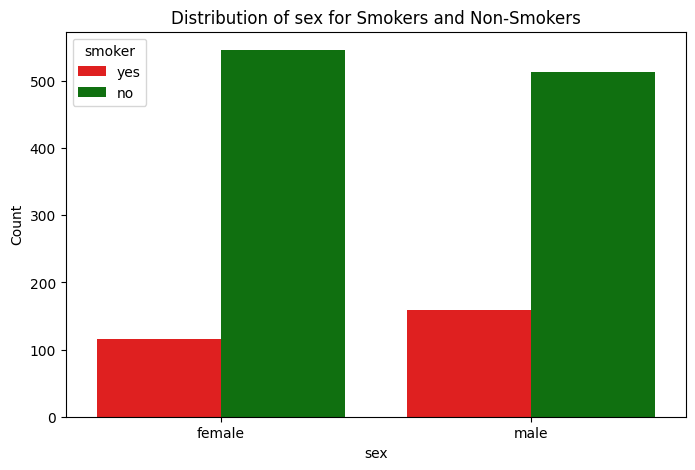

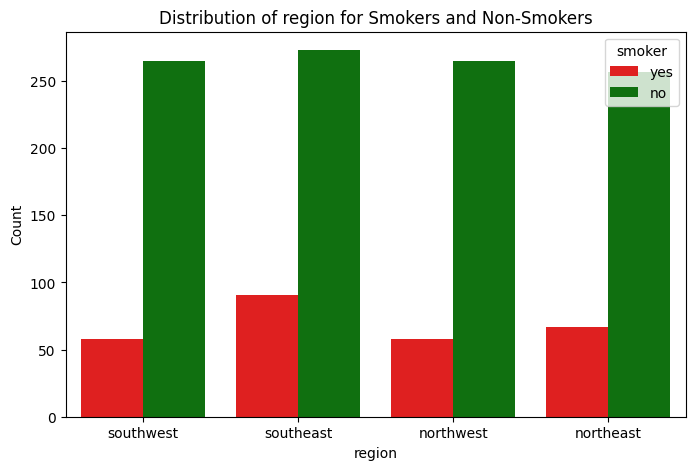

In [ ]:
#define categorical features
categorical_features = ['sex','region']

for feature in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=data, x=feature, hue='smoker', palette={'yes': 'red', 'no': 'green'})
    plt.title(f'Distribution of {feature} for Smokers and Non-Smokers')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

**Gender have no effect on smoking, because the number of males and females that doesn't smoke are nearly the same (517 and 547) and the number of males and females that do smoke are also nearly identical (159 and 115)**

# Convert categorical columns into numerical

In [ ]:
# define dictionary
gender = {'male':0, 'female':1}
# replace sex column with 0/1
data['sex'] = data['sex'].apply(lambda x: gender[x])

smokers = {'no':0, 'yes':1}
data['smoker'] = data['smoker'].apply(lambda x: smokers[x])

region = {'southwest':0, 'southeast':1, 'northwest':2, 'northeast':3}
data['region'] = data['region'].apply(lambda x: region[x])


Check datatype

In [ ]:
data.dtypes

,0
age,int64
sex,int64
bmi,float64
children,int64
smoker,int64
region,int64
charges,float64


# Check correlation between features

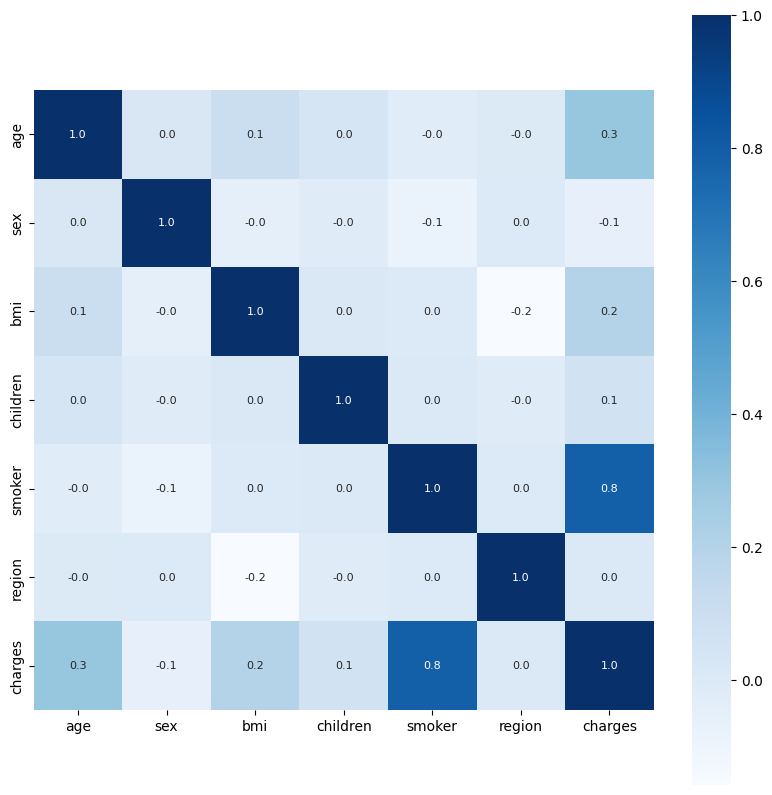

In [ ]:
plt.figure(figsize=(10,10))
correlation= data.corr()
sns.heatmap(correlation,cbar=True,square=True,fmt='.1f',annot=True,annot_kws={'size':8},cmap='Blues')
plt.show()

there is a valuable strong positive relationship between smoker and Medical charges.

**Remove 'region' feature since it has negligeable correlation with other features**

In [ ]:
data.drop('region',axis=1 , inplace= True)

#Scaling and Normalization

In [ ]:
data = data.apply(lambda x: x / x.max(), axis=0)
data.describe()

,age,sex,bmi,children,smoker,charges
count,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000
mean,0.612678,0.495502,0.577103,0.219640,0.205397,0.208436
std,0.219403,0.500167,0.114875,0.241161,0.404143,0.190046
min,0.281250,0.000000,0.300395,0.000000,0.000000,0.017592
25%,0.421875,0.000000,0.494942,0.000000,0.000000,0.074431
50%,0.609375,0.000000,0.571805,0.200000,0.000000,0.147227
75%,0.796875,1.000000,0.652997,0.400000,0.000000,0.262609
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Logistic regression

define independent features X and dependent feature Y, then split them into train and test

In [ ]:
X= data.drop('smoker',axis=1)
Y= data['smoker']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)
print('the size of X train set is',X_train.shape)
print('the size of X test set is',X_test.shape)
print('the size of Y train set is',Y_train.shape)
print('the size of Y test set is',Y_test.shape)

the size of X train set is (1067, 5)
the size of X test set is (267, 5)
the size of Y train set is (1067,)
the size of Y test set is (267,)


Logistic regression

In [ ]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

# Evaluation

In [ ]:

y_pred = model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print('Initial Scores:')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Initial Scores:
Accuracy: 0.9213
Precision: 0.9535
Recall: 0.6833
F1 Score: 0.7961


**Accuracy is good because the model correctly classifies most instances overall (high accuracy ≈ 90%)** <br>
**concerning precision: 95% of predicted smokers were actually smokers, however, it made some false positives.**<br>
**Recall is one of the metric that needs improvement. A recall of 0.6154 means that about 38% of smokers are being missed by the model (false negatives). This is bad especially in healthcare sector.**<br>

**F1 Score it is the harmonic mean of precision and recall, so its value is influenced by the recall score. Improving recall will also improve F1 score.**<br>

**So we can improve Recall while F1 Score will be improved automatically**

# Model improvement

**We will try to improve model performance using 3 methods.**

## Balancing data

 To handle this problem, we choose to do 2 steps:
* Oversampling the minority class
* Undersampling the majority class to obtain the same number in the 2 classes
<br>


In [ ]:
oversample = RandomOverSampler(sampling_strategy=0.5)
X_oversampled, y_oversampled = oversample.fit_resample(X,Y)

undersample = RandomUnderSampler(sampling_strategy=1.0)
X_balanced, y_balanced = undersample.fit_resample(X_oversampled, y_oversampled)

**now, let 's visualize the distribution of smoker column**

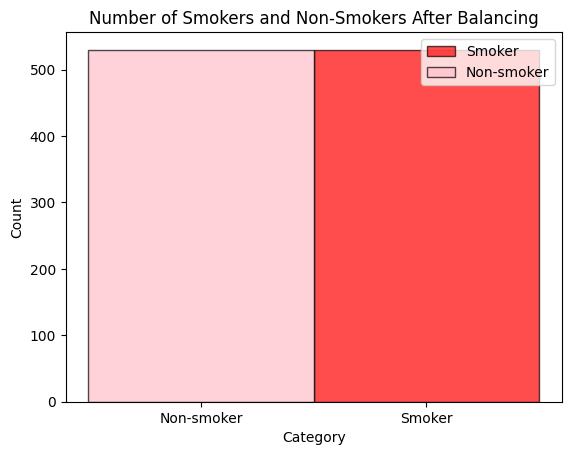

In [ ]:
smokers = y_balanced == 1
non_smokers = y_balanced == 0

plt.hist(y_balanced[smokers], bins=1, edgecolor='black', color='red', alpha=0.7, label='Smoker')
plt.hist(y_balanced[non_smokers], bins=1, edgecolor='black', color='pink', alpha=0.7, label='Non-smoker')

plt.xticks([0, 1], ['Non-smoker', 'Smoker'])
plt.title('Number of Smokers and Non-Smokers After Balancing')
plt.xlabel('Category')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:

#resplit the dataset
X_train,X_test,Y_train,Y_test = train_test_split(X_balanced,y_balanced,test_size=0.2, random_state=42)

log_model = LogisticRegression()
log_model.fit(X_train, Y_train)


#evaluate the model
y_pred = log_model.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print('Initial Scores:')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Initial Scores:
Accuracy: 0.9811
Precision: 0.9612
Recall: 1.0000
F1 Score: 0.9802




1.  **Recall becomes 1, means all actual positive are correctly predicted,no false negative.**
2.   **Acuuracy and F1 score inscreased as well recall increased**



## Regularization with hyperparameter tuning

The code below performs hyperparameter tuning on a Logistic Regression model using GridSearchCV.
It tests different values of:

C (inverse of regularization strength),

penalty ('l1' or 'l2' regularization),

to find the best combination that gives the highest accuracy using 5-fold cross-validation.

Finally, it prints:

The best accuracy score,

The best parameters found during the search.

C controls how much you penalize the model for complexity.

Low C → Strong regularization → Simpler model

High C → Weak regularization → Complex model

In [ ]:
log_model = LogisticRegression(solver='liblinear')

param_grid = {
    'C': [0.1, 1, 10, 100, 1000, 10000],
    #regularization type
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(estimator=log_model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, Y_train)

print(f"Best score: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

Best score: 0.9776
Best parameters: {'C': 10, 'penalty': 'l1'}


In [ ]:

#Let's assess the model's performance in general for the best specified hyperparameters using the same metrics we used earlier.
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
accuracy_3 = accuracy_score(Y_test, y_pred)
precision_3 = precision_score(Y_test, y_pred)
recall_3 = recall_score(Y_test, y_pred)
f1_3 = f1_score(Y_test, y_pred)

print('After Regularization with Hyperparameter Tuning')
print(f"Accuracy of the regularized model: {accuracy_3:.4f}")
print(f"Precision of the regularized model: {precision_3:.4f}")
print(f"Recall of the regularized model: {recall_3:.4f}")
print(f"F1 Score of the regularized model: {f1_3:.4f}")

After Regularization with Hyperparameter Tuning
Accuracy of the regularized model: 0.9858
Precision of the regularized model: 0.9706
Recall of the regularized model: 1.0000
F1 Score of the regularized model: 0.9851


## ADA boosting

AdaBoostClassifier is a boosting algorithm that builds a strong model by combining many weak ones, focusing more on errors made in earlier rounds.

**What is n_estimators?**

n_estimators defines the number of weak learners (models) that AdaBoost will combine to build the final strong classifier.

In [ ]:

#reate an AdaBoostClassifier Model from sklearn library with n_estimators=50, and fit it on the training data you have.
ada_model = AdaBoostClassifier(n_estimators=50, algorithm='SAMME')
ada_model.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME')

In [ ]:
y_pred_ada = ada_model.predict(X_test)

accuracy_ada = accuracy_score(Y_test, y_pred_ada)
precision_ada = precision_score(Y_test, y_pred_ada)
recall_ada = recall_score(Y_test, y_pred_ada)
f1_ada = f1_score(Y_test, y_pred_ada)

print('After AdaBoost:')
print(f"Accuracy of AdaBoost model: {accuracy_ada:.4f}")
print(f"Precision of AdaBoost model: {precision_ada:.4f}")
print(f"Recall of AdaBoost model: {recall_ada:.4f}")
print(f"F1 Score of AdaBoost model: {f1_ada:.4f}")

After AdaBoost:
Accuracy of AdaBoost model: 0.9575
Precision of AdaBoost model: 0.9592
Recall of AdaBoost model: 0.9495
F1 Score of AdaBoost model: 0.9543


## fine tuning of ADA boost model

In [ ]:
ada_model2 = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME']
}

grid_search = GridSearchCV(estimator=ada_model2, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, Y_train)

print(f"Best score: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

best_ada_model = grid_search.best_estimator_
y_pred_ada_tuned = best_ada_model.predict(X_test)

accuracy_ada_tuned = accuracy_score(Y_test, y_pred_ada_tuned)
precision_ada_tuned = precision_score(Y_test, y_pred_ada_tuned)
recall_ada_tuned = recall_score(Y_test, y_pred_ada_tuned)
f1_ada_tuned = f1_score(Y_test, y_pred_ada_tuned)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 

Best score: 0.9693
Best parameters: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 150}


let's evaluate the best ada model

In [ ]:

best_ada_model = grid_search.best_estimator_
y_pred_ada_tuned = best_ada_model.predict(X_test)

accuracy_ada_tuned = accuracy_score(Y_test, y_pred_ada_tuned)
precision_ada_tuned = precision_score(Y_test, y_pred_ada_tuned)
recall_ada_tuned = recall_score(Y_test, y_pred_ada_tuned)
f1_ada_tuned = f1_score(Y_test, y_pred_ada_tuned)

print(f"Accuracy of tuned AdaBoost model: {accuracy_ada_tuned:.4f}")
print(f"Precision of tuned AdaBoost model: {precision_ada_tuned:.4f}")
print(f"Recall of tuned AdaBoost model: {recall_ada_tuned:.4f}")
print(f"F1 Score of tuned AdaBoost model: {f1_ada_tuned:.4f}")

Accuracy of tuned AdaBoost model: 0.9764
Precision of tuned AdaBoost model: 0.9700
Recall of tuned AdaBoost model: 0.9798
F1 Score of tuned AdaBoost model: 0.9749


we can see that all evaluation mertics got better after fine tuning of ADa boosting model

**Final Conclusion:** <br>
All three methods successfully improved the model, with evaluation metrics being very close across models. <br>
Balancing the smoker column and applying regularization helped reduce false negatives, resulting in a recall of 1, which contributed to the increase in both accuracy and F1-score.<br>

While AdaBoost (without fine-tuning) did not completely eliminate false negatives, it still proved effective in enhancing model performance.<br>
The model showed significant improvement after fine-tuning AdaBoost.